# Preprocesamiento de los datos

Para poder entrenar los modelos primero hay que conseguir un dataset. El dataset elegido trae las anotaciones en formato COCO. Primero de todo se extraeran las anotaciones. Después se seleccionarán las especeies a clasificar. Por último se tratarán las imágenes.

# Data preprocessing

To train the models, fristly there has to be a dataset. The chosen dataset brings the annotations in COCO format. First, annotations are extracted. Then species to be classified will be selected. Finally, images will be preprocessed.

In [1]:
#General imports
import random
import json
import os

#Third-party libraries
import numpy as np
import pandas as pd
import cv2
import pickle as pkl

#Visualization
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

#Annotation reader
from pycocotools.coco import COCO

## Extracción de anotaciones

COCO dispone de una API para el tratamiento de anotaciones. Se hará uso de ella para extraer los datos. Las anotaciones vienen en un formato JSON, por lo que podemos leerlas sin uso de su librería, pero facilita la tarea.

## Annotations extraction

COCO has an API for annotation treatment. It will be used to extract data. Annotations are JSON-formatted, so they can be extracted without using the library, but it will simplify the task.

Primero se verán las licencias disponibles para asegurarse de poder usar las imágenes:

First, licenses availables will be shown to assure they can be used rightfully.

In [2]:
with open("../assets/datasets/train_val_annotations/train.json", 'rb') as f:
    json_data = json.load(f)
    
licenses = json_data['licenses']
licenses

[{'id': 1,
  'name': 'CC BY-NC 4.0',
  'url': 'https://creativecommons.org/licenses/by-nc/4.0/'}]

Como se ve, las imágenes solo tienen una licencia, Creative Commons.

As it can be seen, images have only one license, Creative Commons.

A continuación, se hará una lista de las setas que queramos que nuestro clasificador sea capaz de identificar. Esta es una lista de algunas de las setas más buscadas en la provincia de Teruel.

Next, a list of mushrooms we want our classifier to recognize will be done. This is a list of the most searched mushrooms in Teruel county.

In [17]:
fungi = ['Lactarius deliciosus', 'Lactarius sanguifluus', 'Lactarius zonarius',
         'Lactarius chrysorrheus', 'Lactarius salmonicolor','Pleurotus eryngii', 
         'Hygrophorus latitabundus', 'Hygrophorus marzuolus', 'Marasmius oreades',
         'Calocybe gambosa', 'Entoloma lividum', 'Amanita muscaria', 'Boletus pinophilus', 
         'Agaricus arvensis', 'Agaricus xanthodermus', 'Agrocybe aegerita', 
         'Boletus edulis', 'Boletus aereus', 'Amanita caesarea', 'Amanita phalloides']

Se inicializa el 'lector' de aplicaciones COCO.

The COCO applications 'lector' is initialited.

In [18]:
# initialize COCO api for instance annotations
coco=COCO("../assets/datasets/train_val_annotations/train.json")

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


Se seleccionan todas las categorías de la lista disponibles en el dataset.

All cateogories of the list availables in the dataset are selected.

In [19]:
# get categories availables
catIds = coco.getCatIds(catNms=[catNm for catNm in fungi])
catIds
cats = []
for catNm in fungi:
    if (len(coco.getCatIds(catNms=catNm)) != 0):
        cats.append([coco.getCatIds(catNms=catNm), catNm])
cats

[[[578], 'Lactarius deliciosus'],
 [[574], 'Lactarius chrysorrheus'],
 [[684], 'Marasmius oreades'],
 [[109], 'Calocybe gambosa'],
 [[37], 'Amanita muscaria'],
 [[87], 'Boletus pinophilus'],
 [[3], 'Agaricus arvensis'],
 [[22], 'Agaricus xanthodermus'],
 [[83], 'Boletus edulis'],
 [[1281], 'Amanita phalloides']]

Se obtiene las imágenes de cada categoría.

Images of each category are gotten.

In [20]:
# get images of the categories above
imgs = []
data = [[coco.getImgIds(catIds=catId[0])] for catId in cats]
for i in range(len(data)):
    imgs.append(coco.loadImgs([imgId for imgId in data[i][0]]))

Se añade como label el nombre de la especie a cada imagen.

Name of the specie is added to the image as label.

In [21]:
# add label to the image
for i in range(len(data)):
    for img in imgs[i]:
        img['label'] = cats[i][1]

## Creación de un dataframe

Se crea un dataframe de pandas donde se guardarán los datos que hemos extraído del archivo json

## DataFrame creation

A pandas dataframe where extracted data will be stored is created

In [22]:
# create pandas dataframe
df = pd.concat([pd.DataFrame(img) for img in imgs], sort=True)
df.head()

,file_name,height,id,label,license,rights_holder,width
0,images/15834_Lactarius_deliciosus/TKH2013PIC61...,698,71680,Lactarius deliciosus,1,Thomas Kehlet,1024
1,images/15834_Lactarius_deliciosus/APE2017-9208...,1000,129924,Lactarius deliciosus,1,Arne Pedersen,1333
2,images/15834_Lactarius_deliciosus/APE2017-9208...,1000,129925,Lactarius deliciosus,1,Arne Pedersen,750
3,images/15834_Lactarius_deliciosus/APE2017-9208...,1000,129926,Lactarius deliciosus,1,Arne Pedersen,1333
4,images/15834_Lactarius_deliciosus/APE2017-9208...,1000,129927,Lactarius deliciosus,1,Arne Pedersen,1333


In [23]:
# see number of rows and columns of the dataframe
df.shape

(1050, 7)

In [24]:
df.to_csv("./data.csv", sep=',',index=False)

## Obtención de imágenes de un directorio

Se obtienen todas las imágenes que hay en un directorio.

## Obtaining images of a path

All images inside a path are obtained.

In [28]:
def get_images_from_path(path):
    '''Get all images in the given path, even if they are in subdirectories.'''
    images = []
    for directory in os.listdir(path):
        for filename in os.listdir(os.path.join(path, directory)):
            images.append(os.path.join(path, directory, filename))
            
    return images

In [29]:
images = get_images_from_path("../assets/images/")

## Redimensionando

A continuación se redimensionan las imágenes a 224x224 píxeles. 

## Resize

Next, images are resized to 224x224 pixels.

In [26]:
def resize_images(images):
    '''Resize all images given.'''
    WIDTH = 224
    HEIGHT = 224
    n = 0
    
    print("Resizing images: ")
    for img in tqdm(images):
        # Read and resize image
        full_size_image = cv2.imread(img)
        new_size_img = cv2.resize(full_size_image, (WIDTH,HEIGHT), 
                                  interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(img, new_size_img)
        n += 1

    print("Resized "+ str(n) + " images")

In [30]:
resize_images(images)

  0%|          | 0/3120 [00:00<?, ?it/s]

Resizing images: 


100%|██████████| 3120/3120 [00:21<00:00, 146.74it/s]

Resized 3120 images


## Data augmentation

Data-augmentation es una técnica utilizada para aumentar el tamaño del dataset cuando este cuenta con pocos ejempos. Hay muchas maneras de realizarlo, una por ejemplo es invertir las imágenes.

Data-augmentation is a technique used to increase the size of the dataset, when it has few examples. It can be done by several ways, i.e. flipping images.

In [134]:
def flip_images(images):
    '''Flip all images given.'''
    n = 0
    
    print("Flipping images: ")
    for img in tqdm(images):
        # Read and flip the image
        original = cv2.imread(img)
        flipped = np.fliplr(original)
        cv2.imwrite(img.replace(".JPG", "_flipped.jpg"), flipped)
        n += 1
        
    print("Flipped " + str(n) + " images")

In [135]:
flip_images(images)

  1%|          | 18/1766 [00:00<00:09, 178.16it/s]

Flipping images: 


100%|██████████| 1766/1766 [00:08<00:00, 199.32it/s]

Flipped 1766 images


## Creación de un nuevo dataframe

Se ha cambiado el dataset al añadir nuevas imágenes, por lo que hay que actualizarlo.

## Creating a new dataframe

Dataset has been changed when adding new images, so it has to be updated.

In [31]:
def create_dataframe(path):
    '''
    Create a pandas daraframe with two columns, file_name and label, 
    where file_name is the filename and label is the name of the 
    directory where the image is.
    
    Keyword arguments:
    path -- directory where the method will start, inside it 
    must be the directories with the images
    '''
    df = pd.DataFrame(columns=['file_name', 'label'])

    for directory in os.listdir(path):
        for filename in os.listdir(os.path.join(path, directory)):
            with open(os.path.join(path, directory, filename)) as f:
                label = [directory]
                file_name = [os.path.join(path, directory, filename)]
                current_df = pd.DataFrame({'file_name': file_name, 'label': label})
                df = df.append(current_df, ignore_index=True)
    
    return df

In [32]:
df = create_dataframe("../assets/images")

In [11]:
df.to_csv("../assets/datasets/dataframe.csv", index=False)

In [13]:
df = pd.read_csv("../assets/datasets/dataframe.csv")

In [14]:
df.head()

,file_name,label
0,../assets/images/Amanita_muscaria/am43.jpg,Amanita_muscaria
1,../assets/images/Amanita_muscaria/am137.jpg,Amanita_muscaria
2,../assets/images/Amanita_muscaria/am142_flippe...,Amanita_muscaria
3,../assets/images/Amanita_muscaria/am132.jpg,Amanita_muscaria
4,../assets/images/Amanita_muscaria/am164_flippe...,Amanita_muscaria


## Dividir dataset en train y test

Se divide el dataset en datos de entrenamiento y validación

## Split dataset into train and test

Dataset is splitted into train and testing

In [5]:
muscaria = df.loc[df.label == "Amanita_muscaria"]
phalloides = df.loc[df.label == "Amanita_phalloides"]
arvensis = df.loc[df.label == "Agaricus_arvensis"]
xanthodermus = df.loc[df.label == "Agaricus_xanthodermus"]
edulis = df.loc[df.label == "Boletus_edulis"]
gambosa = df.loc[df.label == "Calocybe_gambosa"]
oreades = df.loc[df.label == "Marasmius_oreades"]

In [7]:
muscaria_train = muscaria[:380]
muscaria_test = muscaria[380:]

phalloides_train = phalloides[:328]
phalloides_test = phalloides[328:]

arvensis_train = arvensis[:690]
arvensis_test = arvensis[690:]

xanthodermus_train = xanthodermus[:530]
xanthodermus_test = xanthodermus[530:]

edulis_train = edulis[:340]
edulis_test = edulis[340:]

gambosa_train = gambosa[:250] 
gambosa_test = gambosa[250:]

oreades_train = oreades[:440]
oreades_test = oreades[440:]

In [8]:
df_train = pd.DataFrame(muscaria_train)
df_train = df_train.append(phalloides_train).append(arvensis_train).append(xanthodermus_train)
df_train = df_train.append(edulis_train).append(gambosa_train).append(oreades_train)

In [9]:
df_test = pd.DataFrame(muscaria_test)
df_test = df_test.append(phalloides_test).append(arvensis_test).append(xanthodermus_test)
df_test = df_test.append(edulis_test).append(gambosa_test).append(oreades_test)

In [10]:
df_train = df_train.drop(columns="Unnamed: 0")
df_test = df_test.drop(columns="Unnamed: 0")

In [11]:
df_train.to_csv("../assets/datasets/train.csv")
df_test.to_csv("../assets/datasets/test.csv")

## Carga de imágenes

Se cargan las imágenes para guardar el valor de sus píxeles en arrays de numpy.

## Load images

Images are loaded to store their pixels values in numpy arrays.

In [29]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype=np.uint8 )
    data = np.expand_dims(data, axis=0)
    return data.flatten()

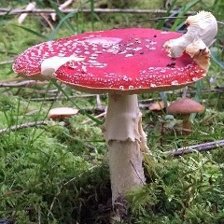

In [36]:
arr = load_image(df_train.iloc[0][0]).reshape(224, 224, 3)
Image.fromarray(arr)

In [45]:
images = []
for filename in df_train[:].file_name:
    img = load_image(filename)
    images.append(img)

labels = df_train.label

with open("../assets/datasets/X_train.pkl", 'wb') as f:
    pkl.dump(np.array(images), f)

with open("../assets/datasets/y_train.pkl", 'wb') as f:
    pkl.dump(np.array(labels), f)

In [46]:
images = []
for filename in df_test[:].file_name:
    img = load_image(filename)
    images.append(img)

labels = df_test.label

with open("../assets/datasets/X_test.pkl", 'wb') as f:
    pkl.dump(np.array(images), f)

with open("../assets/datasets/y_test.pkl", 'wb') as f:
    pkl.dump(np.array(labels), f)